# MLP with MNIST

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import glob
import re
import random

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from model_train import MLP
from utlis.data import data_generation
from metric import winning_rate

# First, check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda
Using device: cuda


In [2]:
# Hyperparameters of the evaluation
load_eval = False # True only if the evaluation have been done before
warm_eval = True # True if we measure the actual effect via warm start

# Hyperparameters of the MIS
k = 50
ks = list(range(1, k+1, 2)) + [k]
methods = ["ZAMinfluence", "Adaptive ZAMinfluence"]
seed = 2
ensemble = 5
train_size = 5000
test_size = 50
step = 5
warm_start = True # Warm_start for adaptive greedy specifically

num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)

def load_results(seed, k, ensemble, step, warm_start=True):
    def aggregate(file_pattern):
        file_paths = glob.glob(os.path.join(directory, file_pattern))

        file_paths = sorted(file_paths, key=lambda x: int(re.search(r'test_(\d+)-(\d+)', x).group(1)))

        results_list = []
        for file_path in file_paths:
            result = torch.load(file_path)
            results_list.append(result)

        # Concatenate all results along the first dimension
        return torch.cat(results_list, dim=0)

    directory = "./results/IF/"

    # Naive greedy result
    file_pattern = f"seed_{seed}_k_{k}_ensemble_{ensemble}_test_*.pt"
    IF_MIS = aggregate(file_pattern)

    # Adaptive greedy result
    if warm_start:
        file_pattern = f"seed_{seed}_k_{k}_ensemble_{ensemble}_adaptive_step_{step}_warm-start_test_*.pt"
    else:
        file_pattern = f"seed_{seed}_k_{k}_ensemble_{ensemble}_adaptive_step_{step}_test_*.pt"

    adaptive_IF_MIS = aggregate(file_pattern)

    return IF_MIS, adaptive_IF_MIS

# Loading Results of MISS: 2d tensor of shape (n_test, k)
IF_MIS, adaptive_IF_MIS = load_results(seed, k, ensemble, step, warm_start)

In [3]:
def actual_effect(subset_remove, original_value, i_th_test, warm_eval=False):
    train_loader, test_loader = data_generation([i for i in range(train_size) if i not in subset_remove], [i_th_test], mode='train')
    reduced_value = 0

    for ensemble_idx in range(ensemble):
        model = MLP().to(device)
        if warm_eval:
            model.load_state_dict(torch.load(f"checkpoint/seed_{seed}_ensemble_{ensemble_idx}.pt", map_location=torch.device('cpu')))
            epochs = 8
        else:
            epochs = 30
        model.train_with_seed(train_loader, epochs=epochs, seed=ensemble_idx, verbose=False)
        reduced_value += model.get_individual_output(test_loader)
    reduced_value /= ensemble
    return reduced_value - original_value

In [4]:
def score(i_th_test, k, original_value):
    scores = np.array([
        actual_effect(IF_MIS[i_th_test, :k], original_value, i_th_test, warm_eval).cpu().detach().numpy(),
        actual_effect(adaptive_IF_MIS[i_th_test, :k], original_value, i_th_test, warm_eval).cpu().detach().numpy()
    ])

    return scores

In [5]:
if load_eval:
    if warm_eval:
        scores_array = np.load(f"results/Eval/scores_seed_{seed}_k_{k}_step_{step}_warm-start.npy")
    else:
        scores_array = np.load(f"results/Eval/scores_array_{seed}_cold_step_{step}.npy")
else:
    train_loader, test_loader = data_generation(list(range(train_size)), list(range(test_size)), mode='train')

    original_value = 0
    for ensemble_idx in range(ensemble):
        model = MLP().to(device)
        model.load_state_dict(torch.load(f"checkpoint/seed_{seed}_ensemble_{ensemble_idx}.pt"))
        original_value += model.get_individual_output(test_loader)

    original_value /= ensemble

    original_value = original_value.cpu().detach().numpy().reshape(-1)

    scores_array = np.array(Parallel(n_jobs=30)(delayed(score)(i, k, original_value[i]) for i in range(num_experiments) for k in ks))
    scores_array = scores_array.reshape((num_experiments, num_ks, -1))
    if warm_eval:
        np.save(f"results/Eval/scores_seed_{seed}_k_{k}_step_{step}_warm-start.npy", scores_array)
    else:
        np.save(f"results/Eval/scores_array_{seed}_cold_step_{step}.npy", scores_array)

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo
scores_ks_method_combo[np.isinf(scores_ks_method_combo)] = 0
scores_ks_method_combo[np.isnan(scores_ks_method_combo)] = 0

scores_ks_method = scores_ks_method_combo.mean(axis=2)

Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda


In [6]:
palette = sns.color_palette("bright")
colors = [palette[8], palette[4]]

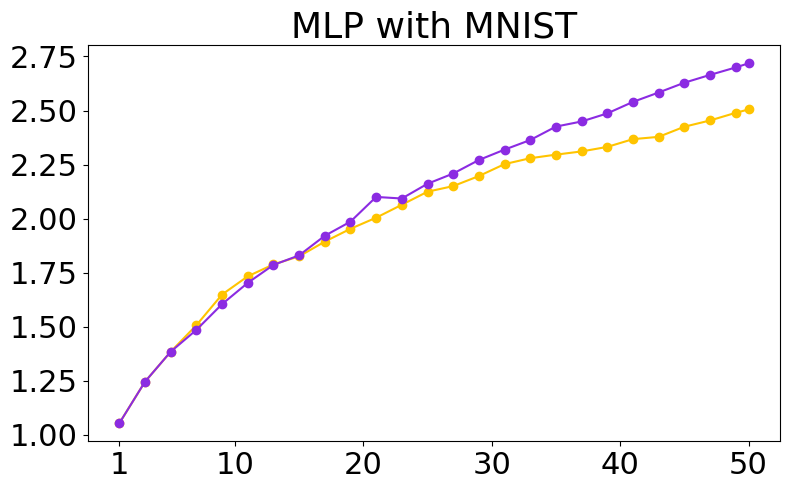

In [7]:
plt.figure(figsize=(8, 5))  # Create a single plot

plt.title(f'MLP with MNIST', fontsize=26)

# plt.xlabel('$k$', fontsize=24)
# plt.ylabel('$\overline{A_{-S}}$', fontsize=24)

for method_idx, method_name in enumerate(methods):
     plt.plot(ks, scores_ks_method[:, method_idx], marker='o', label=method_name, color=colors[method_idx])


plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1), fontsize=22)
plt.yticks(fontsize=22)

# plt.legend(methods, fontsize=22)

plt.tight_layout()

plt.savefig('../Figures/MLP_MNIST_actual.pdf', format='pdf')

plt.show()

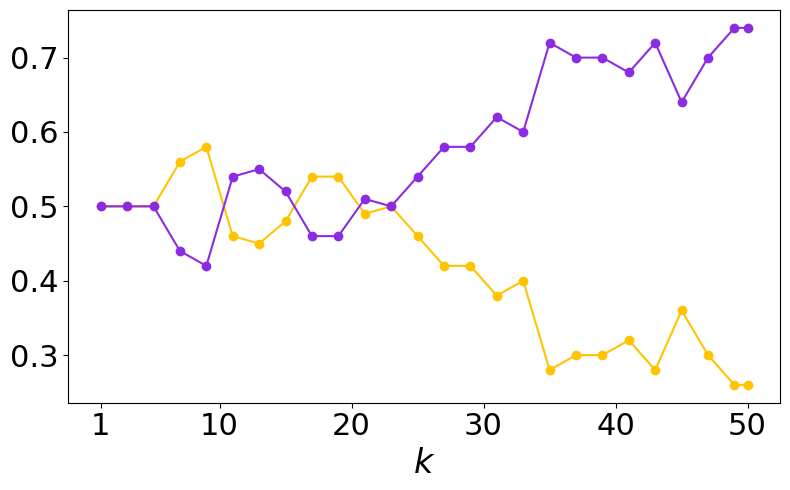

In [8]:
winning_result = np.array(Parallel(n_jobs=50)(delayed(winning_rate)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

plt.figure(figsize=(8, 5))

# plt.title(f'MLP with MNIST', fontsize=26)

plt.xlabel('$k$', fontsize=24)
# plt.ylabel('Winning Rate', fontsize=24)

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, winning_result[:, method_idx], marker='o', label=method_name, color=colors[method_idx])

plt.yticks(fontsize=22)
plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1), fontsize=22)

# plt.legend(methods, fontsize=22)

plt.tight_layout()

plt.savefig('../Figures/MLP_MNIST_winning.pdf', format='pdf')

plt.show()